# Выбор модели машинного обучения для классификации участков по яркости в каналах и спектральным индексам

В файле `choose_ml_algorithm.ipynb` показан процесс предварительной подготовки данных для обучения и выбора одной из четырех моделей классического машинного обучения на основе скорости выполнения алгоритма и точности выделения всех классов. Наилучшая модель сохранена в файл модели для дальнейшего использования.

## Импорт библиотек и дополнительные установки

In [ ]:
import warnings
import os
import joblib
from osgeo import gdal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    train_test_split,
    LearningCurveDisplay,
    learning_curve,
)

from clearings_extraction_algorithm import (
    ImageDataset,
    LandClassModel,
    rasterize_polygons,
    make_feature_matrix,
)

In [30]:
warnings.filterwarnings("ignore")
gdal.UseExceptions()
gdal.AllRegister()

In [31]:
%matplotlib inline
sns.set_style("ticks")

## Создание наборов данных на экспериментальные участки

Класс `ImageDataset` позволяет создать наборы данных космических снимков как в виде 3d матрицы размером (высота, ширина, кол-во каналов), позволяющей взаимодействовать с каждым спектральным каналом отдельно и пространственно отобразить результаты на карте, так и в виде 2d матрицы размером (высота*ширина, кол-во каналов), которую можно применить при обучении модели классификации.

In [32]:
polygons_sets = [
    os.path.join(r"./polygons_sets/", file)
    for file in os.listdir("./polygons_sets/")
    if file.endswith(".shp")
]

summer_images = [
    r".\images\experimental_areas_images\small_areas_images\sentinel2_2016_06_1_1.tif",
    r".\images\experimental_areas_images\small_areas_images\sentinel2_2016_06_2_1.tif",
    r".\images\experimental_areas_images\small_areas_images\sentinel2_2020_06_3_1.tif",
]

winter_images = [
    r".\images\experimental_areas_images\small_areas_images\sentinel2_2017_01_1_1.tif",
    r".\images\experimental_areas_images\small_areas_images\sentinel2_2017_01_2_1.tif",
    r".\images\experimental_areas_images\small_areas_images\sentinel2_2017_02_3_1.tif",
]

rasterized_polygons_path = r".\polygons_sets\polygons_set.gtif"

image_datasets = []
feature_matrices = []

In [33]:
for polygon_set, summer_image, winter_image in zip(
    polygons_sets, summer_images, winter_images
):
    roi = rasterize_polygons(polygon_set, summer_image, rasterized_polygons_path)
    image_dataset = ImageDataset()
    image_dataset.create_dataset(summer_image, winter_image)
    image_dataset.make_image_2d()
    image_datasets.append(image_dataset)
    data = make_feature_matrix(roi, image_dataset.image_data_3d)
    feature_matrices.append(data)

In [34]:
image_dataset_1, image_dataset_2, image_dataset_3 = (
    image_datasets[0].image_data_3d,
    image_datasets[1].image_data_3d,
    image_datasets[2].image_data_3d,
)
img_2d_arr_1, img_2d_arr_2, img_2d_arr_3 = (
    image_datasets[0].image_data_2d_arr,
    image_datasets[1].image_data_2d_arr,
    image_datasets[2].image_data_2d_arr,
)
data_1, data_2, data_3 = feature_matrices[0], feature_matrices[1], feature_matrices[2]

Матрицы объект-признак, полученные на каждый экспериментальный участок, объединяются в одну:

In [35]:
data_merged = pd.concat([data_1, data_2], ignore_index=True)
data = pd.concat([data_merged, data_3], ignore_index=True)

Количество пикселей в пяти классах разнится, что может негативно сказаться на результатах классификации - модели классификации будут переоценивать класс с наибольшим числом пикселей. Поэтому проведено уравнивание числа пикселей:

In [36]:
pixels_per_class = data["class"].value_counts().sort_values(ascending=True)
min_samples_number = pixels_per_class.index[0]
min_samples = pixels_per_class.min()
print(f"Класс с минимальным числом пикселей - класс № {min_samples_number}")
print(f"Всего в классе № {min_samples_number} содержится {min_samples} пикселей")

Класс с минимальным числом пикселей - класс № 2
Всего в классе № 2 содержится 3109 пикселей


Таким образом, число пикселей в каждом классе было сокращено до значения `min_samples`:

In [37]:
np.random.seed(10)

class_label_numbers = [1, 2, 3, 4, 5]
class_label_numbers.remove(min_samples_number)

for label in class_label_numbers:
    n_samples_drop = data["class"].value_counts()[label] - min_samples
    indices_to_drop = np.random.choice(
        data[data["class"] == label].index, n_samples_drop, replace=False
    )
    data = data.drop(indices_to_drop)

In [38]:
data["class"].value_counts()

class
1    3109
4    3109
2    3109
5    3109
3    3109
Name: count, dtype: int64

Из набора выборок пикселей создается матрица объект-признак `X` и вектор меток классов `y`.

In [39]:
X = data.drop("class", axis=1)
y = data["class"]

Для модели KNN подобран один гиперпараметр - количество соседей для проведения голосования `n_neighbors`, равный 5. Данный параметр существенно влияет как на время обработки данных, так и на метрики качества классификации. Причем при меньшем числе соседей вероятно переобучение, а при большем числе возможно значительное увеличение времени на прогноз меток класса.

В свою очередь, для модели логистической регрессии наибольшее влияние на качество результата оказывает норма регуляризации (гиперпараметр `penalty`) - гиперпараметр, который штрафует высокие значения коэффициентов уравнения и уменьшает вес малозначимых коэффициентов практически до нуля и коэффициент регуляризации уравнения регрессии (гиперпараметр `C`), который контролирует силу регуляризации. Для параметра нормы установлено значение `l2`, так как при норме `l1` возможно обнуление некоторых признаков уравнения регрессии, что приводит к ухудшению классификации.

Как и для модели логистической регрессии, в модели SVM норма регуляризации `penalty` и коэффициент регуляризации `C` оказывают значительное влияние на результат классификации. В случае модели SVM установлена аналогичная норма регуляризации, а значение коэффициента регуляризации понижено.

В модели случайного леса наибольшее влияние на качество прогноза влияют такие показатели как максимальная глубина дерева `max_depth` и минимальная убыль значения коэффициента Джинни `min_impurity_decrease`- критерия который рассчитывает степень информативности разделения текущего узла на две части.

In [40]:
knn = LandClassModel(
    model=KNeighborsClassifier(n_neighbors=5), model_name="k-ближайших соседей"
)
logreg = LandClassModel(
    model=LogisticRegression(penalty="l2", C=0.1), model_name="логистическая регрессия"
)
svm = LandClassModel(
    model=LinearSVC(penalty="l2", C=0.01), model_name="метод опорных векторов"
)
rf = LandClassModel(
    model=RandomForestClassifier(
        n_estimators=100, max_depth=4, min_impurity_decrease=0.01, random_state=42
    ),
    model_name="случайный лес",
)

Для поиска оптимального соотношения для разделения генеральной выборки на обучающую и тестовую производится построение обучающих кривых для каждой модели классификации, созданной выше. Показатель accuracy подходит для настоящей выборки, так как классы сбалансированы.

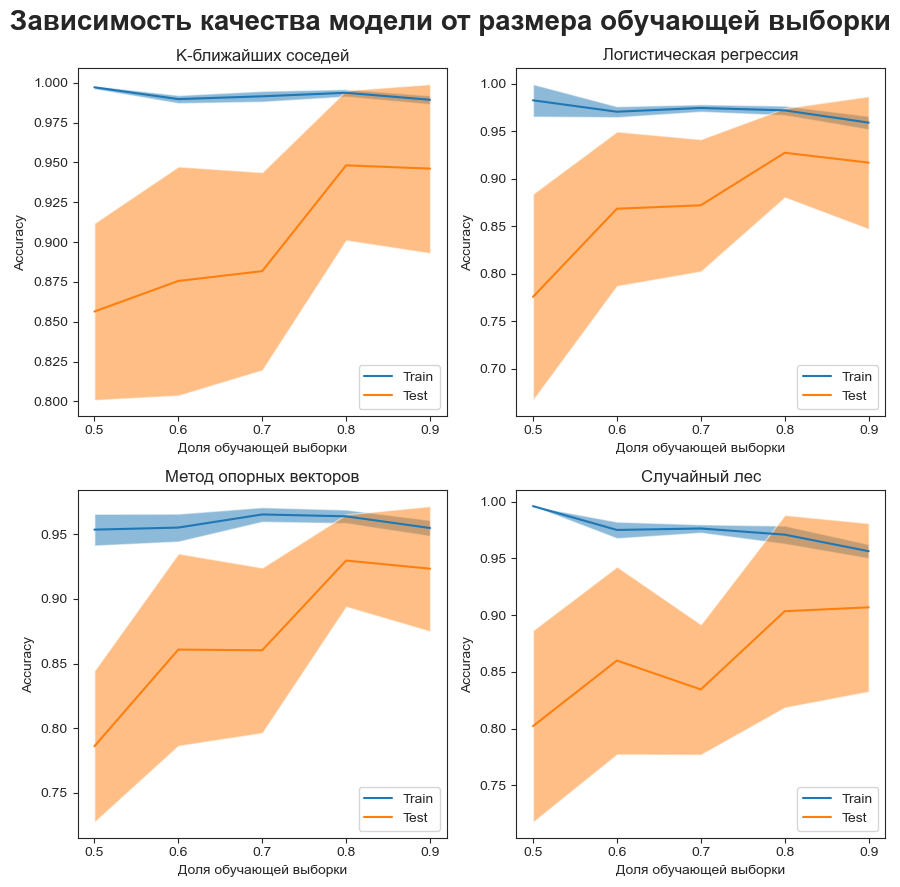

In [41]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(9, 9))
axes = axes.ravel()
for ml_model, i in zip([knn, logreg, svm, rf], [0, 1, 2, 3]):
    train_sizes, train_scores, test_scores = learning_curve(ml_model.model, X, y)
    display = LearningCurveDisplay(
        train_sizes=[0.5, 0.6, 0.7, 0.8, 0.9],
        train_scores=train_scores,
        test_scores=test_scores,
    )
    display.plot(ax=axes[i])
    axes[i].set_title(ml_model.model_name.capitalize())
    axes[i].legend()
    axes[i].set_xlabel("Доля обучающей выборки")
    axes[i].set_ylabel("Accuracy")
plt.suptitle(
    "Зависимость качества модели от размера обучающей выборки",
    fontsize=20,
    fontweight=600,
)
plt.tight_layout()

При доле обучающей выборки от 0.5 до 0.8 показатель accuracy для тестовой выборки монотонно возрастает и достигает максимального значения при доле 0.8. При увеличении доли обучающей выборки до 0.9 качество прогнозирования на обучающей выборке уменьшается, а качество прогнозирования на тестовой выборке практически не меняется, при этом доверительный интервал метрики увеличивается. Поэтому в качестве оптимального разделения выборки на обучающую и тестовую соответственно выбрано соотношение 80:20.


In [42]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=42
)

## Создание карты классификации территории тестовых участков на основе методов машинного обучения

**k-ближайших соседей**

Отчет о модели: k-ближайших соседей
-----------------------------------------------------------------
Метрики качества классификации:
Accuracy: 0.984
Kappa score: 0.98
F1 score: 0.984
-----------------------------------------------------------------
Матрица несоответствий:


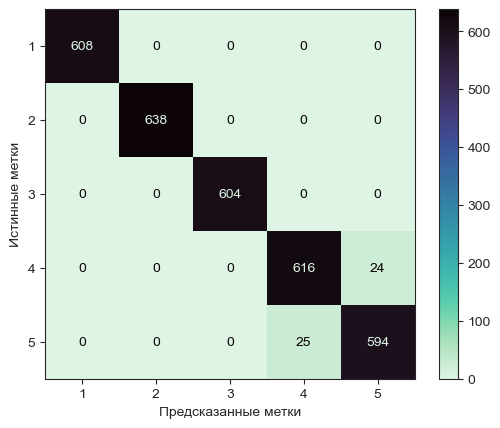

-----------------------------------------------------------------
Среднее время выполнения:
Время выполнения для участка № 1: 5.134375e+01 секунд
Время выполнения для участка № 2: 4.090625e+01 секунд
Время выполнения для участка № 3: 4.940625e+01 секунд
--------------------------------------------------------


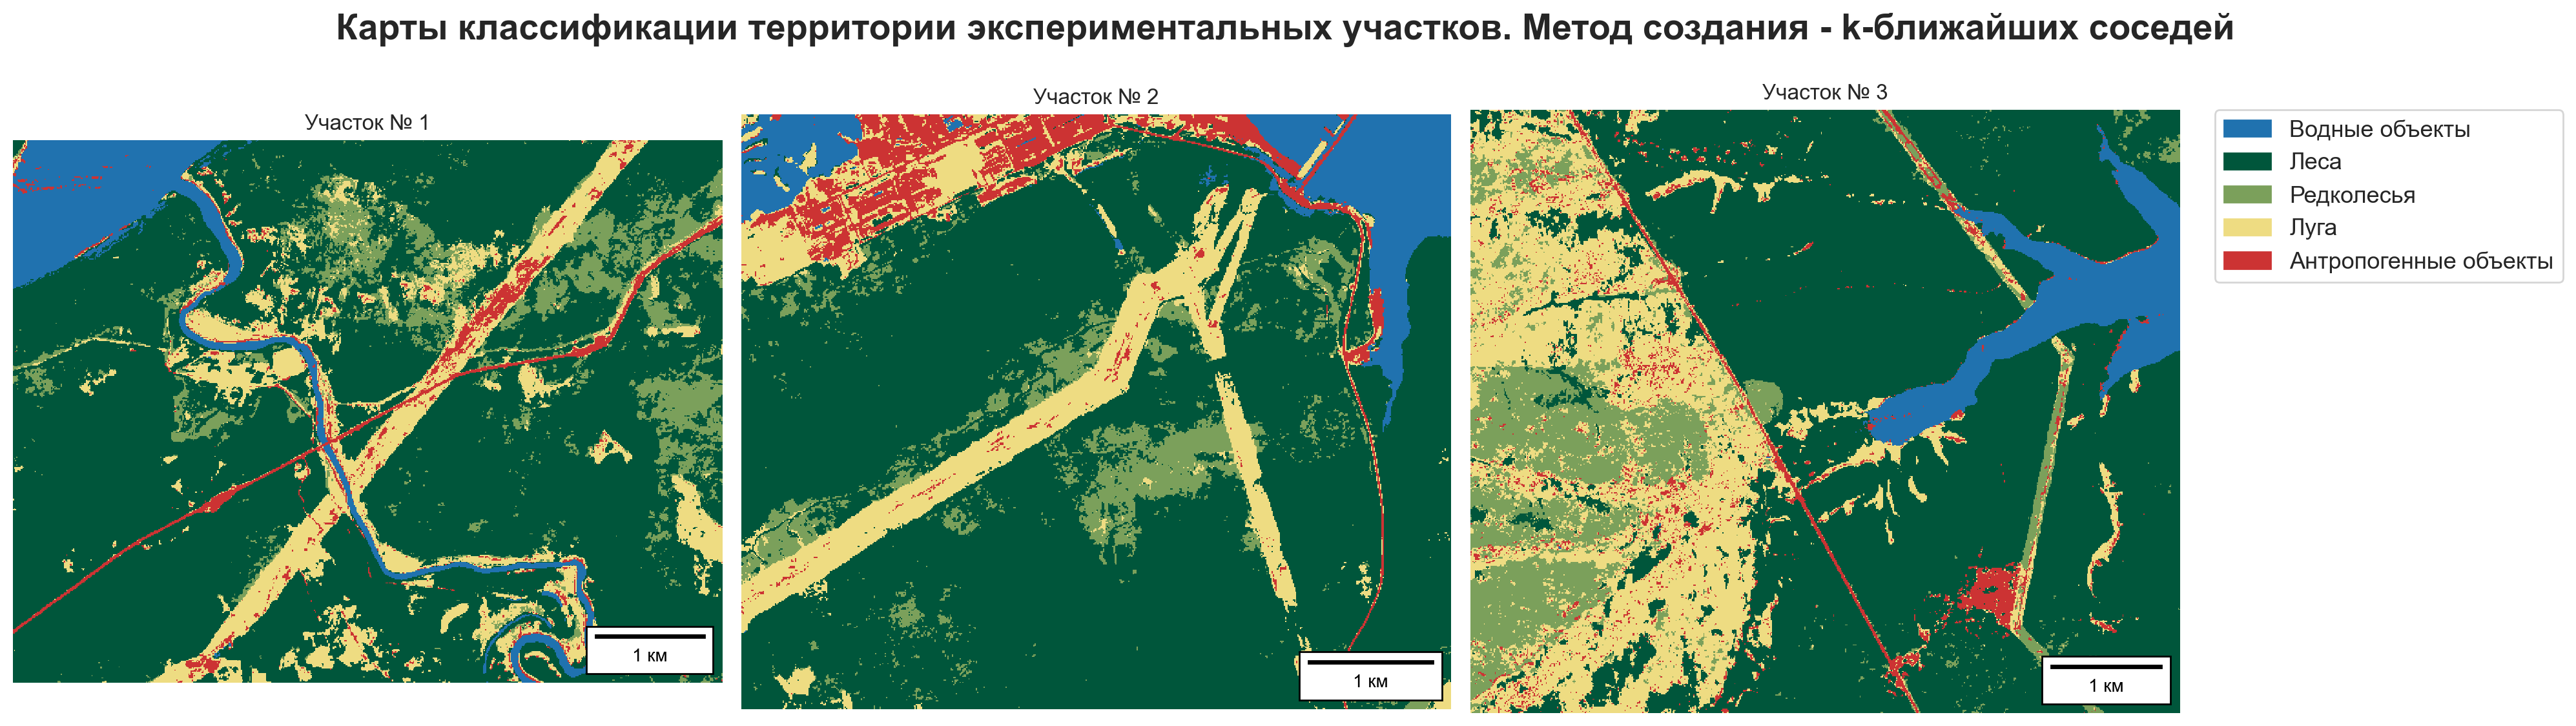

In [43]:
knn_pred_maps = []
img_arrays = [img_2d_arr_1, img_2d_arr_2, img_2d_arr_3]
img_datasets = [image_dataset_1, image_dataset_2, image_dataset_3]
knn.make_model_report(
    X_train,
    y_train,
    X_test,
    y_test,
    img_arrays,
    img_datasets,
    knn_pred_maps,
)

**Логистическая регрессия**

Отчет о модели: логистическая регрессия
-----------------------------------------------------------------
Метрики качества классификации:
Accuracy: 0.96
Kappa score: 0.95
F1 score: 0.96
-----------------------------------------------------------------
Матрица несоответствий:


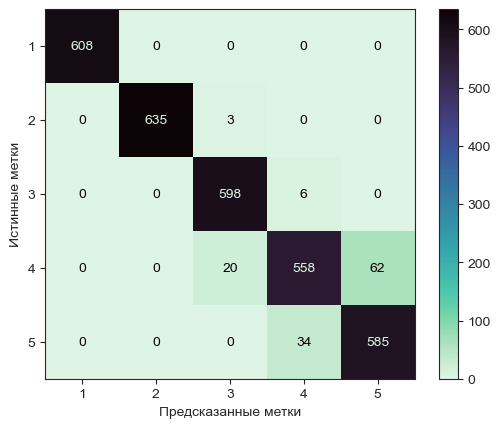

-----------------------------------------------------------------
Среднее время выполнения:
Время выполнения для участка № 1: 2.812500e-01 секунд
Время выполнения для участка № 2: 1.875000e-01 секунд
Время выполнения для участка № 3: 2.812500e-01 секунд
--------------------------------------------------------


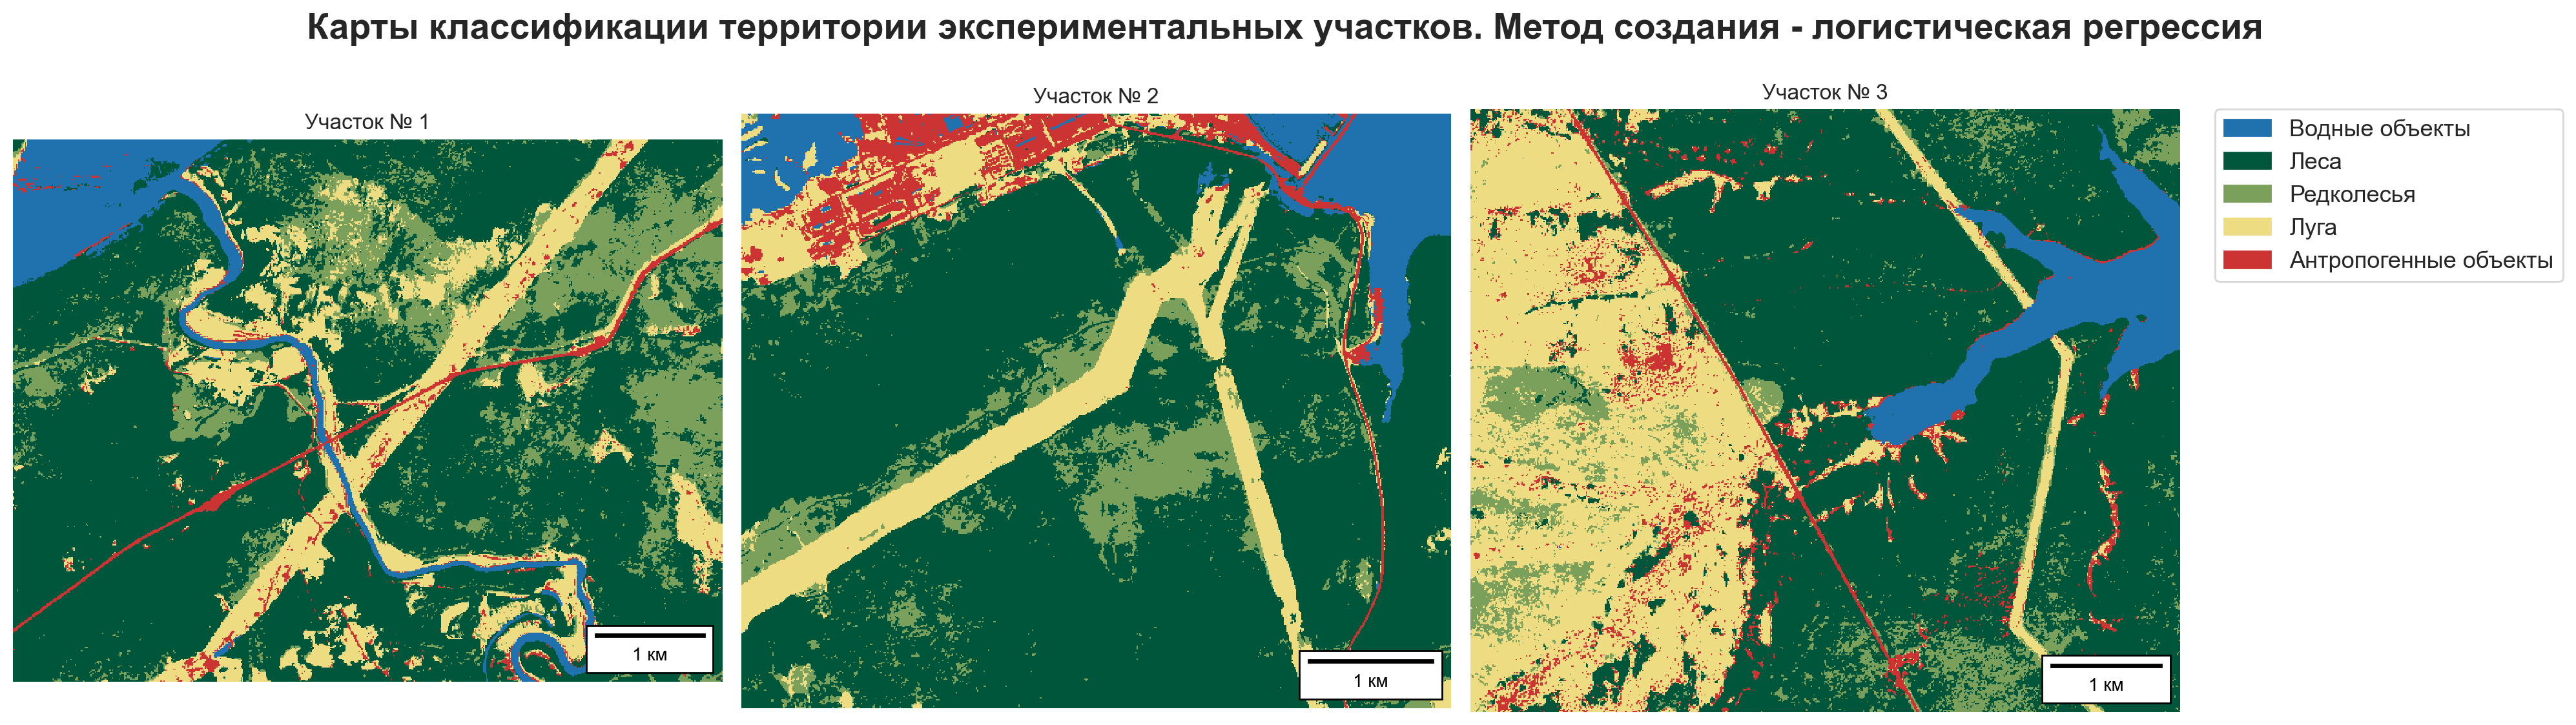

In [44]:
logreg_pred_maps = []
img_arrays = [img_2d_arr_1, img_2d_arr_2, img_2d_arr_3]
img_datasets = [image_dataset_1, image_dataset_2, image_dataset_3]
logreg.make_model_report(
    X_train,
    y_train,
    X_test,
    y_test,
    img_arrays,
    img_datasets,
    logreg_pred_maps,
)

**Метод опорных векторов**

Отчет о модели: метод опорных векторов
-----------------------------------------------------------------
Метрики качества классификации:
Accuracy: 0.959
Kappa score: 0.949
F1 score: 0.959
-----------------------------------------------------------------
Матрица несоответствий:


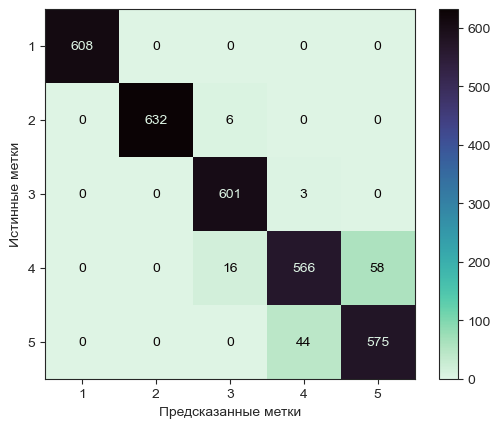

-----------------------------------------------------------------
Среднее время выполнения:
Время выполнения для участка № 1: 2.812500e-01 секунд
Время выполнения для участка № 2: 2.812500e-01 секунд
Время выполнения для участка № 3: 2.812500e-01 секунд
--------------------------------------------------------


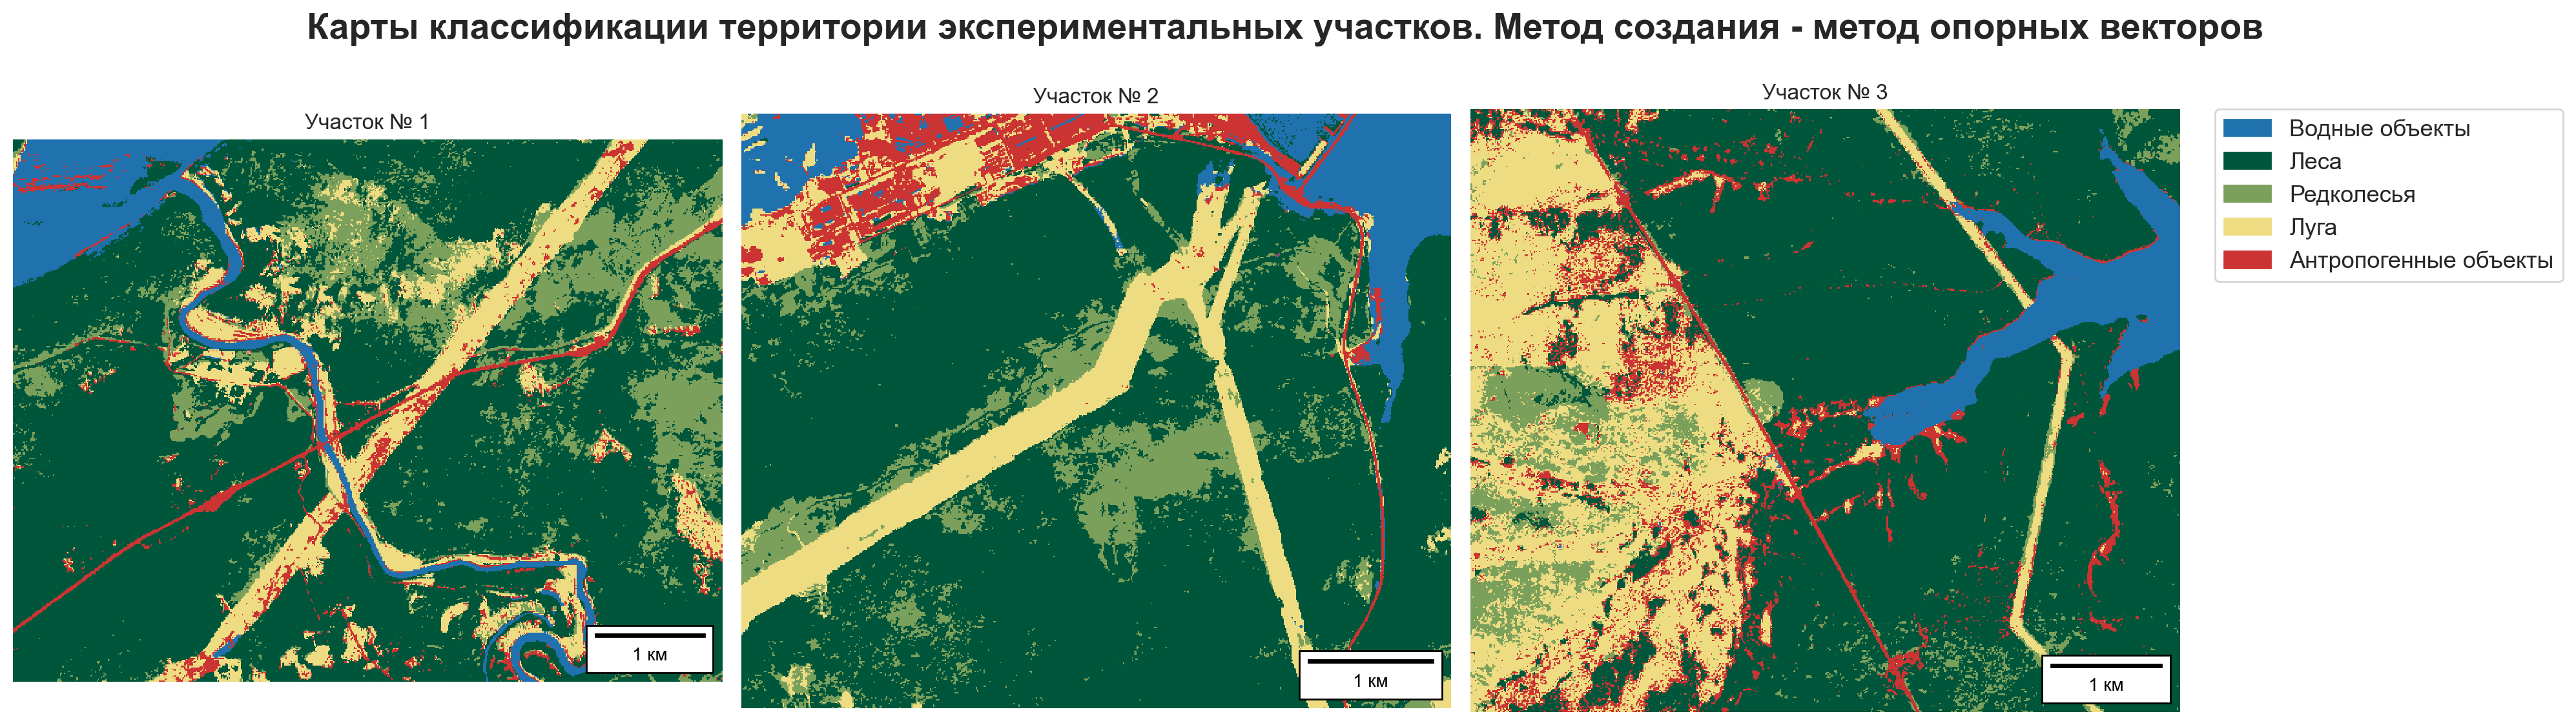

In [45]:
svm_pred_maps = []
img_arrays = [img_2d_arr_1, img_2d_arr_2, img_2d_arr_3]
img_datasets = [image_dataset_1, image_dataset_2, image_dataset_3]
svm.make_model_report(
    X_train,
    y_train,
    X_test,
    y_test,
    img_arrays,
    img_datasets,
    svm_pred_maps,
)

**Случайный лес**

Отчет о модели: случайный лес
-----------------------------------------------------------------
Метрики качества классификации:
Accuracy: 0.955
Kappa score: 0.944
F1 score: 0.956
-----------------------------------------------------------------
Матрица несоответствий:


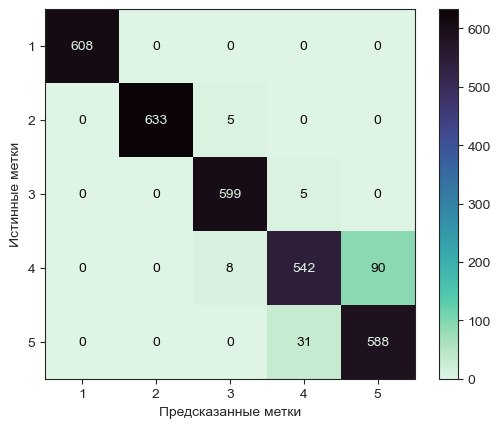

-----------------------------------------------------------------
Среднее время выполнения:
Время выполнения для участка № 1: 1.625000e+00 секунд
Время выполнения для участка № 2: 1.328125e+00 секунд
Время выполнения для участка № 3: 1.890625e+00 секунд
--------------------------------------------------------


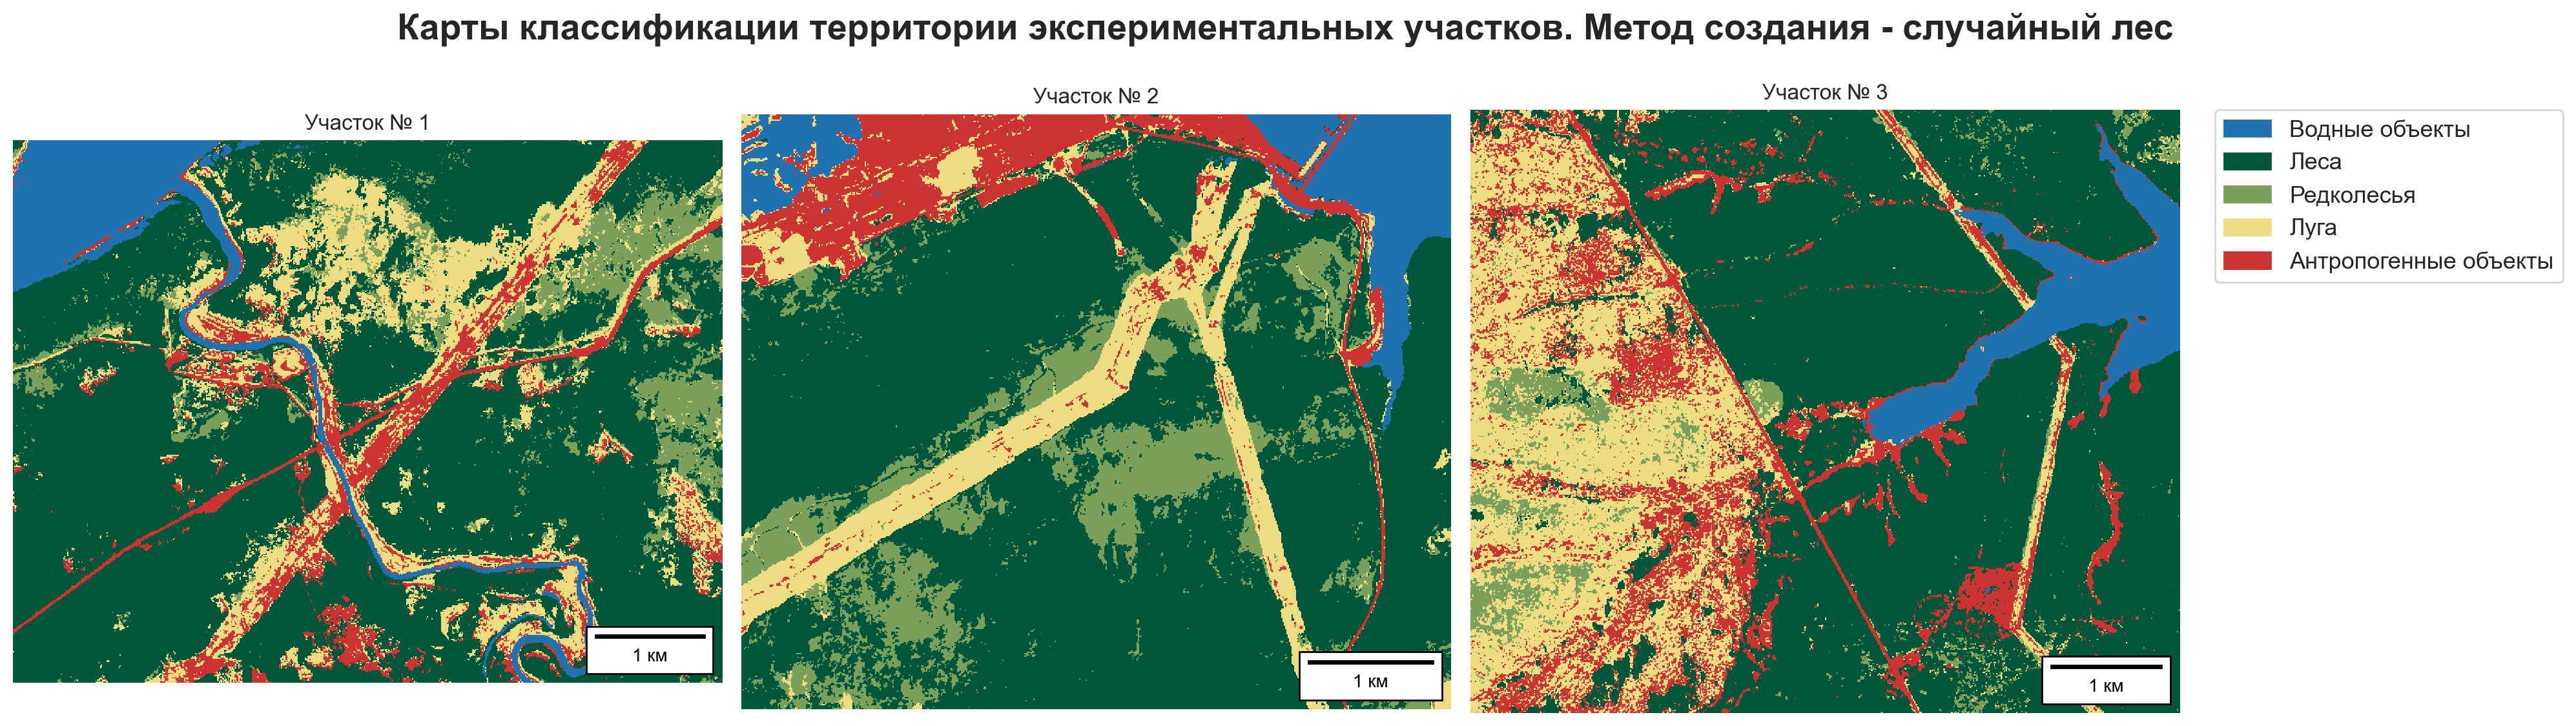

In [46]:
rf_pred_maps = []
img_arrays = [img_2d_arr_1, img_2d_arr_2, img_2d_arr_3]
img_datasets = [image_dataset_1, image_dataset_2, image_dataset_3]
rf.make_model_report(
    X_train,
    y_train,
    X_test,
    y_test,
    img_arrays,
    img_datasets,
    rf_pred_maps,
)

По метрикам качества классификации и по картам классификации модель логистической регрессии оказывается наилучшей моделью. Помимо высоких значений метрик качества классификации и скорости вычислений модель логистической регрессии подходит под задачу выделения лесных просек тем, что она легко интерпретируема. Для интерпретации модели создается матрица важности коэффициентов модели:

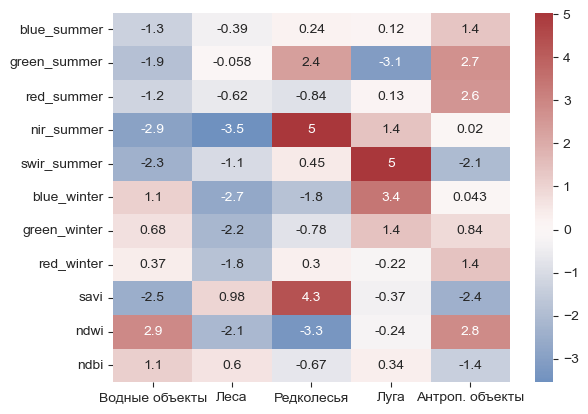

In [47]:
lst_columns = list(X_train.columns)
coef_importance = pd.DataFrame(index=lst_columns)
for class_name, class_coef in zip(
    ["Водные объекты", "Леса", "Редколесья", "Луга", "Антроп. объекты"],
    logreg.model.coef_,
):
    coef_importance[class_name] = class_coef

sns.heatmap(coef_importance, annot=True, cmap="vlag", center=0)

file_name = "coef_importance_heatmap.svg"
file_path = os.path.join("svg_plots", file_name)
plt.savefig(file_path, format="svg", dpi=300, bbox_inches="tight")
plt.show()

Сохраним модель в файл `.joblib`:

In [48]:
joblib.dump(logreg.model, "model/logistic_regression.joblib")

['model/logistic_regression.joblib']